# SRGAN

In [1]:
import os
import matplotlib.pyplot as plt

from data import Thermal
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [3]:
Thermal_train = Thermal(scale=4, subset='train', downgrade='bicubic')
Thermal_valid =Thermal(scale=4, subset='valid', downgrade='bicubic')

In [4]:
train_ds = Thermal_train.dataset(batch_size=1, random_transform=True)
valid_ds = Thermal_valid.dataset(batch_size=1, random_transform=True, repeat_count=1)

LR_Image Directory:
can_edge_data/Thermal_train_LR_bicubic/X4
HR_Image Directory:
can_edge_data/Thermal_train_HR
LR_Image Directory:
can_edge_data/Thermal_valid_LR_bicubic/X4
HR_Image Directory:
can_edge_data/Thermal_valid_HR


## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://martin-krasser.de/sisr/weights-srgan.tar.gz) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Generator pre-training

In [5]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=242000, 
                  evaluate_every=1000, 
                  save_best_only=True)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

Model restored from checkpoint at step 242000.


In [6]:
import tensorflow as tf
print(tf.__version__)

2.4.1


### Generator fine-tuning (GAN)

In [ ]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=10000)

50/10000, perceptual loss = 0.0098, discriminator loss = 2.8123
100/10000, perceptual loss = 0.0090, discriminator loss = 1.9464
150/10000, perceptual loss = 0.0136, discriminator loss = 2.1226
200/10000, perceptual loss = 0.0130, discriminator loss = 2.5159
250/10000, perceptual loss = 0.0119, discriminator loss = 2.2925
300/10000, perceptual loss = 0.0133, discriminator loss = 1.8676
350/10000, perceptual loss = 0.0148, discriminator loss = 1.6390
400/10000, perceptual loss = 0.0145, discriminator loss = 1.4939
450/10000, perceptual loss = 0.0147, discriminator loss = 1.4843
500/10000, perceptual loss = 0.0150, discriminator loss = 1.4082
550/10000, perceptual loss = 0.0177, discriminator loss = 1.4145
600/10000, perceptual loss = 0.0150, discriminator loss = 1.7308
650/10000, perceptual loss = 0.0151, discriminator loss = 1.6190
700/10000, perceptual loss = 0.0106, discriminator loss = 1.7673
750/10000, perceptual loss = 0.0077, discriminator loss = 1.5465
800/10000, perceptual loss

In [7]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

## Demo

In [5]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [10]:
from model import resolve_single
from utils import load_image
import numpy as np
import cv2
import tensorflow as tf
from utils import load_image, plot_sample
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import cv2

def resolve_and_plot(lr_image_path, hr_image_path):
    lr = load_image(lr_image_path)
    lr = cv2.cvtColor(lr, cv2.COLOR_GRAY2BGR)
    hr = load_image(hr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    #images = [lr, pre_sr, gan_sr, hr]
    images = [lr, pre_sr, gan_sr]
    #titles = ['LR', 'SR (PRE)', 'SR (GAN)', 'HR']
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    #positions = [1,2,3,4]
    positions = [1,3,4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    
    mse = tf.keras.losses.MeanSquaredError()
    sr2 = cv2.cvtColor(np.float32(gan_sr), cv2.COLOR_BGR2GRAY)
    ssim_e = ssim(sr2, hr, data_range=hr.max() - hr.min())
    print(ssim_e)
    
    

0.9825674486749177


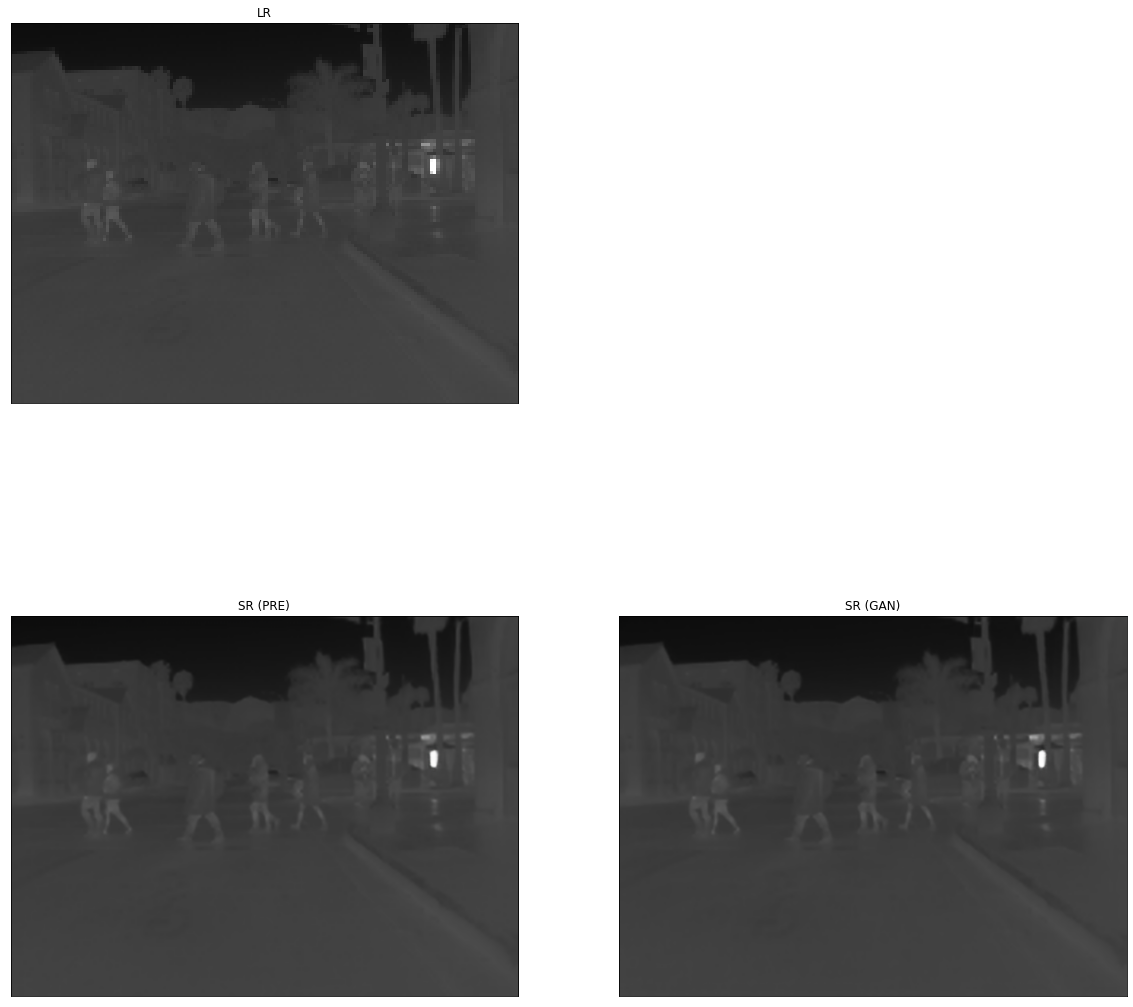

In [11]:
resolve_and_plot('demo/0004x4.png', 'demo/0004.png')

0.9564065661298683


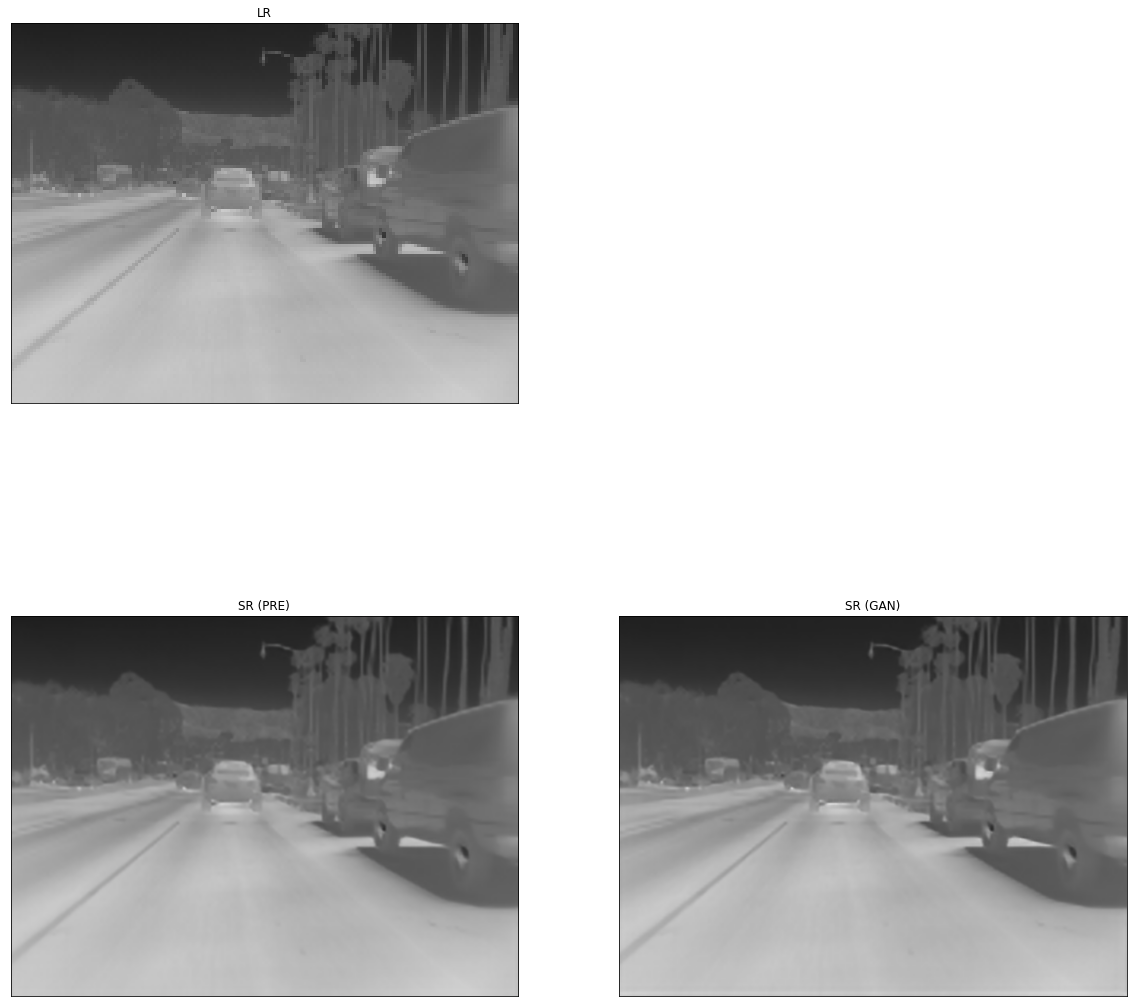

In [12]:
resolve_and_plot('demo/1064x4.png','demo/1064.png')

0.8771759261792085


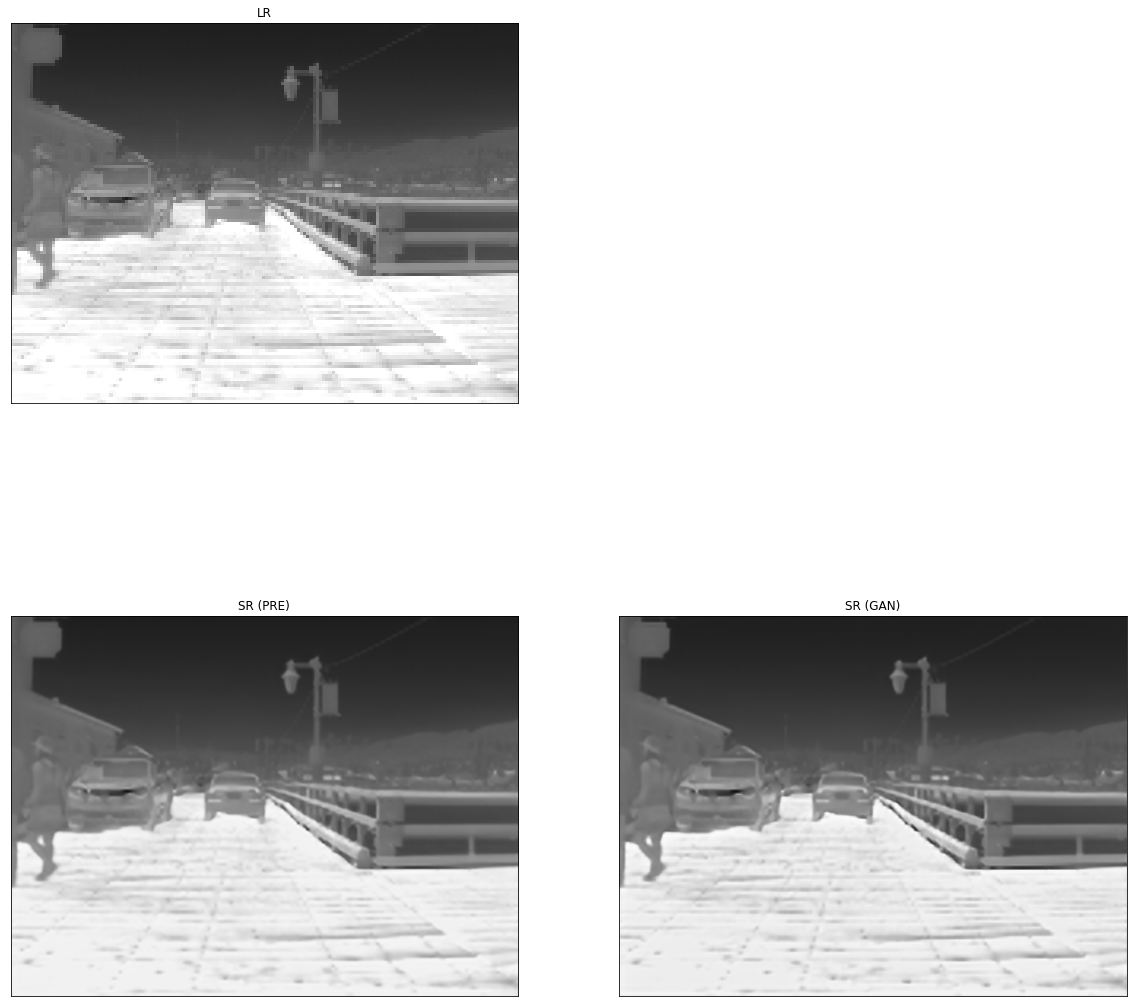

In [13]:
resolve_and_plot('demo/0303x4.png', 'demo/0303.png')